In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import clip
from models import TransformerClassifier
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = 'adm'
os.makedirs(f'./weights/{dataset}', exist_ok=True)
os.makedirs(f'./results/{dataset}', exist_ok=True)

In [4]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model.float()

student_model = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=4, dropout=0.2, batch_first=True), num_layers=1).to(device).eval()
student_model.load_state_dict(torch.load(f"./weights/{dataset}/student.pth", weights_only=True))

teacher_model = TransformerClassifier().to(device).eval()
teacher_model.load_state_dict(torch.load(f"./weights/{dataset}/teacher.pth", weights_only=True))
teacher_model = create_feature_extractor(teacher_model, return_nodes={"transformer_encoder": "layer1"})

classifier = TransformerClassifier().to(device)

In [5]:
train_path = f'./data/{dataset}/train'

train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

train_folder, val_folder = random_split(train_folder, [0.8, 0.2])

train_loader = DataLoader(train_folder, batch_size=64, shuffle=True)
val_loader = DataLoader(val_folder, batch_size=64, shuffle=False)

In [6]:
# _datasets = ['adm', 'biggan', 'glide', 'midjourney', 'sdv5', 'vqdm', 'wukong']

# train_folders = []
# val_folders = []

# for ds in _datasets:
# 	train_path = f'./data/{ds}/train'

# 	train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

# 	train_folder, val_folder = random_split(train_folder, [0.8, 0.2])
# 	train_folders.append(train_folder)
# 	val_folders.append(val_folder)
 
# train_folder = ConcatDataset(train_folders)
# val_folder = ConcatDataset(val_folders)

# train_loader = DataLoader(train_folder, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_folder, batch_size=16, shuffle=False)

In [7]:
# def _convert_image_to_rgb(image):
#     return image.convert("RGB")

# def _transform(n_px = 224, flip_mode = None):
#     flip = {
#         None: [],
# 		1: [transforms.RandomHorizontalFlip(p=1)],
# 		2: [transforms.RandomVerticalFlip(p=1)],
# 		3: [transforms.RandomHorizontalFlip(p=1), transforms.RandomVerticalFlip(p=1)]
# 	}
#     return transforms.Compose([
#         transforms.Resize(n_px, interpolation=transforms.InterpolationMode.BICUBIC),
#         transforms.CenterCrop(n_px),
#         *flip[flip_mode],
#         _convert_image_to_rgb,
#         transforms.ToTensor(),
#         transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
#     ])

In [8]:
# train_path = f'./data/{dataset}/train'

# train_folder = datasets.ImageFolder(root=train_path, transform=_transform())
# train_folder1 = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=1))
# train_folder2 = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=2))
# train_folder3 = datasets.ImageFolder(root=train_path, transform=_transform(flip_mode=3))

# train_folder = ConcatDataset([train_folder, train_folder1, train_folder2, train_folder3])

# train_folder, val_folder = random_split(train_folder, [0.8, 0.2])

# train_loader = DataLoader(train_folder, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_folder, batch_size=64, shuffle=False)

In [9]:
num_epochs = 20

optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-5)

loss_fn = torch.nn.CrossEntropyLoss()

result = []

In [10]:
min_val_loss = float('inf')

for epoch in range(num_epochs):
    
    with tqdm(total=len(train_loader), desc=f'Train Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        teacher_model.train()
        running_loss = 0.0
        correct = 0
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(images)
                student_output = student_model(image_features)
                teacher_output = teacher_model(image_features)['layer1']
            logits = classifier(torch.pow(student_output - teacher_output, 2))
            loss = loss_fn(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/(batch+1)})
            pbar.update()
            
        train_loss = running_loss/len(train_loader)
        train_acc = correct/len(train_loader.dataset)*100
        pbar.set_postfix({'loss': train_loss, 'acc': train_acc})
    
    with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        teacher_model.eval()
        with torch.inference_mode():
            running_loss = 0.0
            correct = 0
            for batch, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                image_features = clip_model.encode_image(images)
                student_output = student_model(image_features)
                teacher_output = teacher_model(image_features)['layer1']
                logits = classifier(torch.pow(student_output - teacher_output, 2))
                
                running_loss += loss_fn(logits, labels).item()
                predictions = torch.argmax(logits, dim=-1)
                correct += (predictions == labels).sum().item()
                
                pbar.set_postfix({'loss': running_loss/(batch+1)})
                pbar.update()
                
        val_loss = running_loss/len(val_loader)
        val_acc = correct/len(val_loader.dataset)*100
        pbar.set_postfix({'loss': val_loss, 'acc': val_acc})
                
    result.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
    result_df = pd.DataFrame(result)
    result_df.to_csv(f'./results/{dataset}/classifier.csv', index=False)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(classifier.state_dict(), f'./weights/{dataset}/classifier.pth')

Train Epoch 1/20:   0%|          | 0/50 [00:00<?, ?batch/s]c:\Users\hoang\xldl\.venv\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Validation Epoch 20/20: 100%|██████████| 13/13 [00:06<00:00,  2.02batch/s, loss=0.184, acc=95]


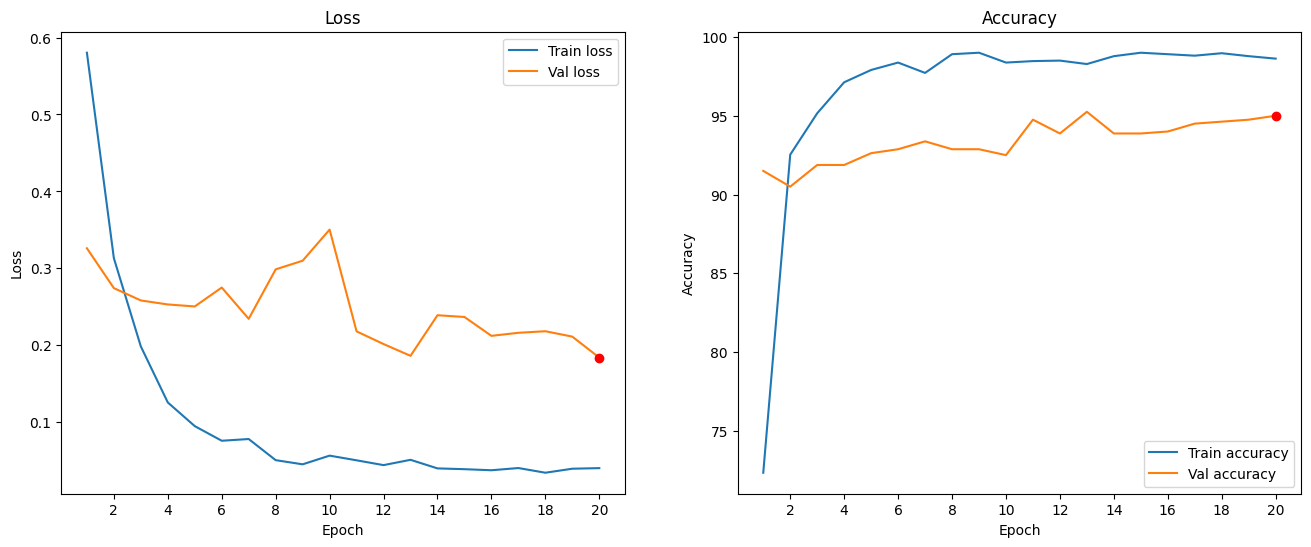

In [11]:
result = pd.read_csv(f'./results/{dataset}/classifier.csv')

min_val_loss = float('inf')
for _, row in result.iterrows():
    if row['val_loss'] < min_val_loss:
        min_val_loss = row['val_loss']
        min_val_loss_row = row
        
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(result['epoch'], result['train_loss'], label='Train loss')
ax[0].plot(result['epoch'], result['val_loss'], label='Val loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_xticks(result['epoch'][1::2])
ax[0].plot(min_val_loss_row['epoch'], min_val_loss_row['val_loss'], 'ro')
ax[0].legend()

ax[1].plot(result['epoch'], result['train_acc'], label='Train accuracy')
ax[1].plot(result['epoch'], result['val_acc'], label='Val accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticks(result['epoch'][1::2])
ax[1].plot(min_val_loss_row['epoch'], min_val_loss_row['val_acc'], 'ro')
ax[1].legend()